# End-to-end Multi-class Dog Breed Classification

This notebook builds an end to end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Project 

Identifying the breed of a dog fiven an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification copetition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

The evalution is afile with prediction probabilities for each dog breed of each test image.


https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features 

Some information about the data:
* We're dealing with `images` (unstructured data) so it's probably best we use deep learning / Transfer learning 

* There are 120 breeds of dogs (this means there are 120 different classes).

* There are around 10,000+ `images` in the training set (these `images` have labels)

* There are around 10,000+ `images` in the test set (these `images` dont have lables, because we'll want to predict them).

 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np

### Get our workspace ready.

* Import Tensorflow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU



In [3]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version: ", hub.__version__)

# Check for GPU availability 
print("GPU", "available (YESS!!!)" if tf.config.list_physical_devices('GPU') else "not available")

TF version: 2.11.0
TF Hub version:  0.13.0
GPU available (YESS!!!)


## Getting our data ready (turneing into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's star by accessing our data and checking out the labels

In [4]:
# Checkout the labels of our data

import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: >

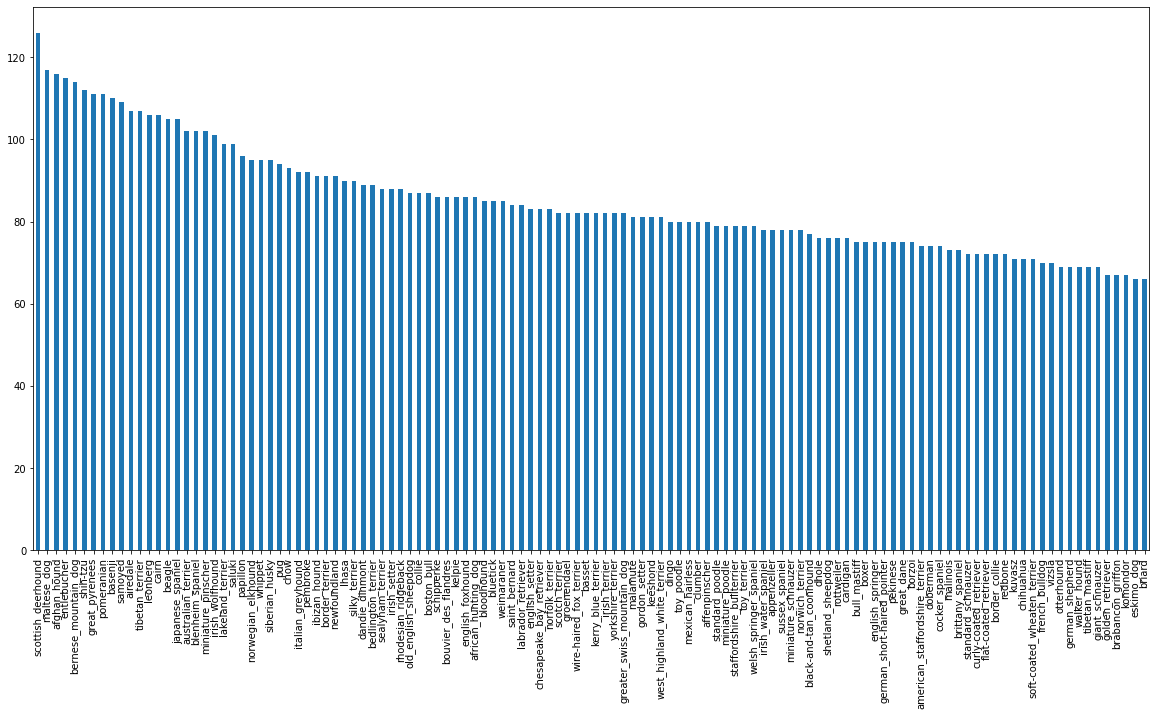

In [5]:
# How many images are there of each breed
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))

In [6]:
labels_csv['breed'].value_counts().median()

82.0

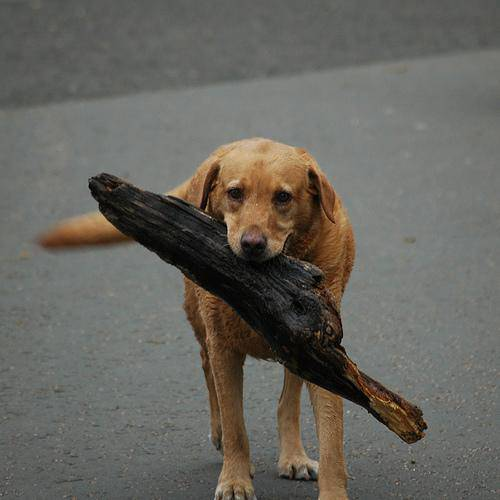

In [7]:
# Let's view an image 
from IPython.display import Image 
Image("/content/drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [8]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
# Create pathnames from image ID's 
filenames = ["/content/drive/MyDrive/Dog Vision/train/"+fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['/content/drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# Check whether number of filenmaes matches number of actual image files 
import os
if len(os.listdir("drive/My Drive/Dog Vision/train")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory. ")

Filenames match actual amount of files!!! Proceed.


Since we've now got our training image filepaths in a list, let's prepare our lables.

In [11]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) - does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
len(labels)

10222

In [13]:
# See if number of labels matches the number of filenames 
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data dirrectories!")

Number of labels matches number of filenames!


In [14]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [15]:
len(unique_breeds)

120

In [16]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [17]:
len(boolean_labels)

10222

In [18]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurss
print(boolean_labels[0].argmax()) #index where lable occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [19]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [20]:
# Setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimeting with 1000 images and increase as needed.

In [21]:
# Set number of images to use for experimenting

NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000}


In [22]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

### Preprocess Images (turning images into tensors)

To preprocess our images into Tensors we're going to write a funciton which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

Before we do, let's see what importing an image looks like.


In [23]:
# Convert image to numpy 

from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [24]:
image.max(), image.min()

(255, 0)

In [25]:
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

Now we've see what an image looks like a Tensor, let's make a function to preprocess them.

1. Take an image filepath as input 
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` (convert color channel values from 0-255 to 0-1 values)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified image

In [26]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def preprocess_image(image_path):
  """
  Takes an image file path and turns the image into a Tensor.
  """

  # Read in an image file 
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0 - 255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image



```
# This is formatted as code
```

## Turning our data into batches

Why turn our data into batches?
  Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

  So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

  In order to use Tensorflow effectively, we need our data in the form of Tensor tuples which look like this : `(image, label).`

In [27]:
# Create a simple function to return a tuple (image, label)
def get_image_label (image_path, label):
  """
  Takes an image file path names and the associated label, 
  processes the image and returns a tuple of (image, label).
  """

  image = preprocess_image(image_path)
  return image, label


In [28]:
# Demo of the above 
(preprocess_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, Let's make a function to turn all of our data `(X, y)` into batches.

In [29]:
# Define the batch size, 32 is a good start 
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches (X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's a training data. but doesn't shuffle if it's a validation data.
  Also accepts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches........")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no lables)
    data_batch = data.map(preprocess_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it 
  elif valid_data:
    print("Creating validation data batches.....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                              tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  # If the data is a train dataset, we just shuffle and batching them
  else:
    print("Creating training data batches.....")
    # Turn filepaths and labels into Tensors 
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images 
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches 
    data_batch = data.batch(BATCH_SIZE)
    return data_batch






In [30]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True) 

Creating training data batches.....
Creating validation data batches.....


In [31]:
# Check out the different attributes of our data batches 
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches 

Our data is now in batches, however, these can be little hard to understand/comprehend, let's visualize them!

In [32]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images (images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))

  #Loop through 25 (for displaying 25 images)
  for i in range (25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display the image 
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [33]:
train_images, train_labels=next(train_data.as_numpy_iterator())

len(train_images), len(train_labels)

(32, 32)

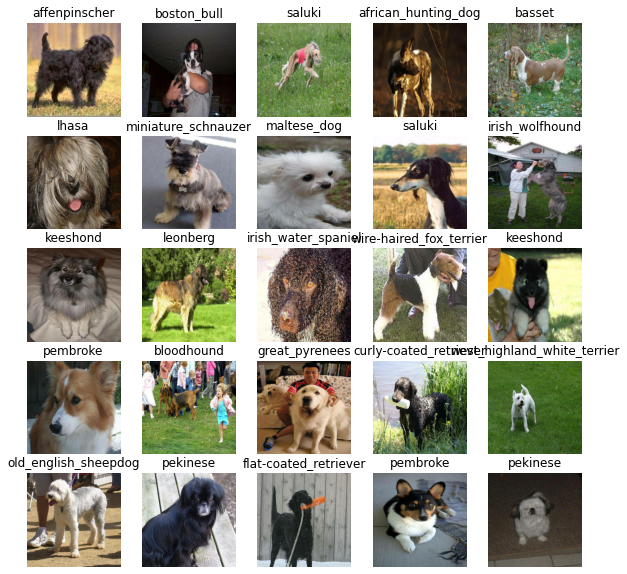

In [34]:
# Now let's visualise the data in a training batch
train_images, train_labels=next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

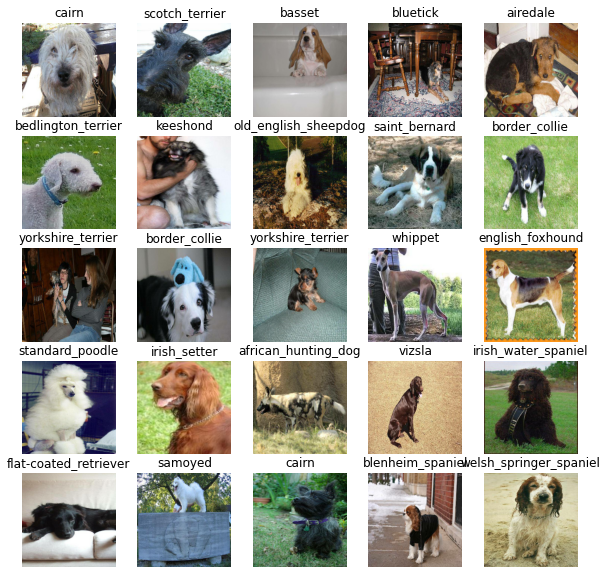

In [35]:
# Now let's visualise our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
  * The input shape (our images shape, in the form of Tensors) to our model.
  * The output shape (image labels, in the form of Tensors) of our model.
  * The URL of the model we want to use from TensorFlow Hub.

In [36]:
# Setup input shape to the model 
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape to the model 
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs, outputs and model ready to go. Let's put them together into Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've choosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here. https://www.tensorflow.org/guide/keras/sequential_model


In [37]:
# Create a function which builds a Keras model 
def create_model(input_shape = INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: ", MODEL_URL)

  # Setup the model layers 
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
      tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                            activation="softmax") #Layer 2 (output layer)
      
  ])

  # Compile the model 
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics=["Accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [38]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [39]:
outputs = np.ones(shape=(1,1, 1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll gonna create a two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

## TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:

  1. Load the TensorBoard notebook extension 
  2. Create a Tensorboard callback which is able to save logs to a directory and pass it to our logs to a directory and pass it to our model's `fit()` function. 
  3. Visualise our models training logs with the %tensorboard magic function (we'll do this after model training).

In [40]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [41]:
import datetime 

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run as experiment 
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tf.keras.callbacks.TensorBoard(logdir) 


### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [42]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience = 3)


## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [43]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [44]:
# Check to make sure we're still running on a GPU

print("GPU", "available (YESSSS!!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESSSS!!!!!!!)


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
* Return the model.

In [45]:
# Build a function to train and return a trained model 
def train_model():
  """
  Trains a given model and returns the trained version.
  """

  # Create a model 
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # Return the fitted model 
  return model 

In [46]:
# # Fit the model to the data 
# model = train_model() 

**Question:** It looks like our model is fitting becase it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks??

**Note:** Overfitting to begin with is a good thing! It means our model is learning!!

### Checking the TensorBoard logs 

The TensorBoard magic functions ('%tensorboard') will access the logs directory we created earlier and visualise its contents.

In [47]:
# !kill
# %tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs --port=6007

## Making and evaluating predictions using a trained model 

In [48]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [49]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose =1)
predictions

7/7 [==============================] - 49s 7s/step


array([[0.00172866, 0.00147442, 0.00198699, ..., 0.00822231, 0.00126573,
        0.00388449],
       [0.00074015, 0.00220943, 0.00481751, ..., 0.00122819, 0.00303221,
        0.00056618],
       [0.0099361 , 0.01300886, 0.00431573, ..., 0.00103369, 0.00477765,
        0.00045571],
       ...,
       [0.0190066 , 0.00158118, 0.00052887, ..., 0.02261217, 0.00071529,
        0.01092423],
       [0.01526094, 0.08089375, 0.0036567 , ..., 0.00638505, 0.00034777,
        0.00372648],
       [0.00665264, 0.00490962, 0.00134603, ..., 0.02630217, 0.01695188,
        0.0005936 ]], dtype=float32)

In [50]:
len(predictions[0])

120

In [51]:
np.sum(predictions[0])

0.99999994

In [52]:
predictions.shape

(200, 120)

In [53]:
len(y_val)

200

In [54]:
len(unique_breeds)

120

In [55]:
# First Prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max Index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[0.0540475  0.00042129 0.00658152 0.01450039 0.00231884 0.0182471
 0.00035507 0.00110445 0.00084938 0.00183991 0.00199762 0.00132388
 0.00495925 0.00094545 0.04020114 0.01106989 0.01144677 0.01892439
 0.01684691 0.02167968 0.0039971  0.0026608  0.02187191 0.01167859
 0.10210364 0.00058585 0.01444945 0.01814323 0.00227922 0.00629474
 0.02819004 0.00366203 0.01050224 0.01305433 0.01039181 0.0007211
 0.00123117 0.00187219 0.00818233 0.01018649 0.00189121 0.00047763
 0.00864494 0.0141026  0.00097191 0.00119184 0.00225097 0.0195379
 0.01556839 0.00083443 0.00112371 0.00795394 0.00440612 0.00341646
 0.00155136 0.0093262  0.01225147 0.00106307 0.00079389 0.00332573
 0.01340931 0.00338688 0.01309252 0.00777147 0.00178493 0.0007404
 0.00419877 0.03498644 0.01116643 0.00800589 0.01031655 0.03199745
 0.01032194 0.01279129 0.00461565 0.00986084 0.01202546 0.0083066
 0.00448236 0.00099056 0.00425561 0.0018635  0.00112576 0.00393818
 0.00182956 0.00644572 0.00697705 0.00070536 0.00207739 0.00322725


Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Predictions probablities are also known as confidence levels.

In [56]:
# Turn predicition probabilities into their respective label (easier to understand)

def get_pred_label(prediction_probabilites):
  """
  Turns an array of prediction probabilites into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilites)]

# Get a predicted label based on a array of prediction probabilites 
pred_label = get_pred_label(predictions[0])
pred_label

'american_staffordshire_terrier'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth lables).

In [57]:
val_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [58]:
# Create a function to unbatch a batch dataset

def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate 
  arrays of images and labels.
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [59]:
get_pred_label(val_labels[0])

'affenpinscher'

In [60]:
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

images_[0], labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [61]:
get_pred_label(labels_[0])

'cairn'

In [62]:
get_pred_label(predictions[0])

'american_staffordshire_terrier'

Now we've got ways to get :
* Predicition labels 
* Validation label (truth labels)
* Validation images 

Let's make some function to make these all a bit more visualize.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and integers. 
* Convert the prediction probabilites to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.

In [63]:
def plot_pred(prediction_probabilites, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample m
  """

  pred_prob, true_label, image = prediction_probabilites[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label 
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color = color)

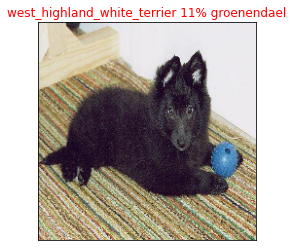

In [64]:
plot_pred(prediction_probabilites=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualise our models top prediction, let's make another to view our models top 10 predictions 

This function will:

  * Take an input of predicition probabilities array and a ground truth array and an integer 
  * Find the prediction using `get_pred_label()`
  * Find the top 10:
      * Prediction probabilites indexes
      * Prediction probabilites values 
      * Prediction labels 
  * Plot the top 10 prediction probability values and labels, coloring the true label given.

In [65]:
def plot_pred_conf(prediction_probabilites, labels, n=1):
  """
  Plus the top 10 highest prediction confidence along with the truth label for sample n.
  """

  pred_prob, true_label = prediction_probabilites[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 predictions confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values 
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 Prediction labels 
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation="vertical")      
  
  # Change the color of the true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass 


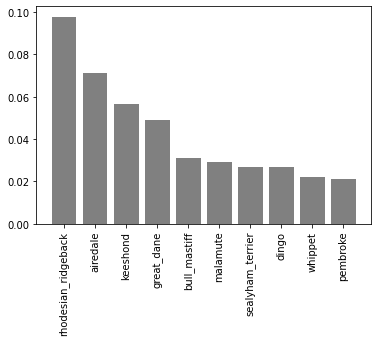

In [66]:
plot_pred_conf(prediction_probabilites=predictions,
               labels=val_labels,
               n=9)

Now we've got some function to help us visualise our prediction.

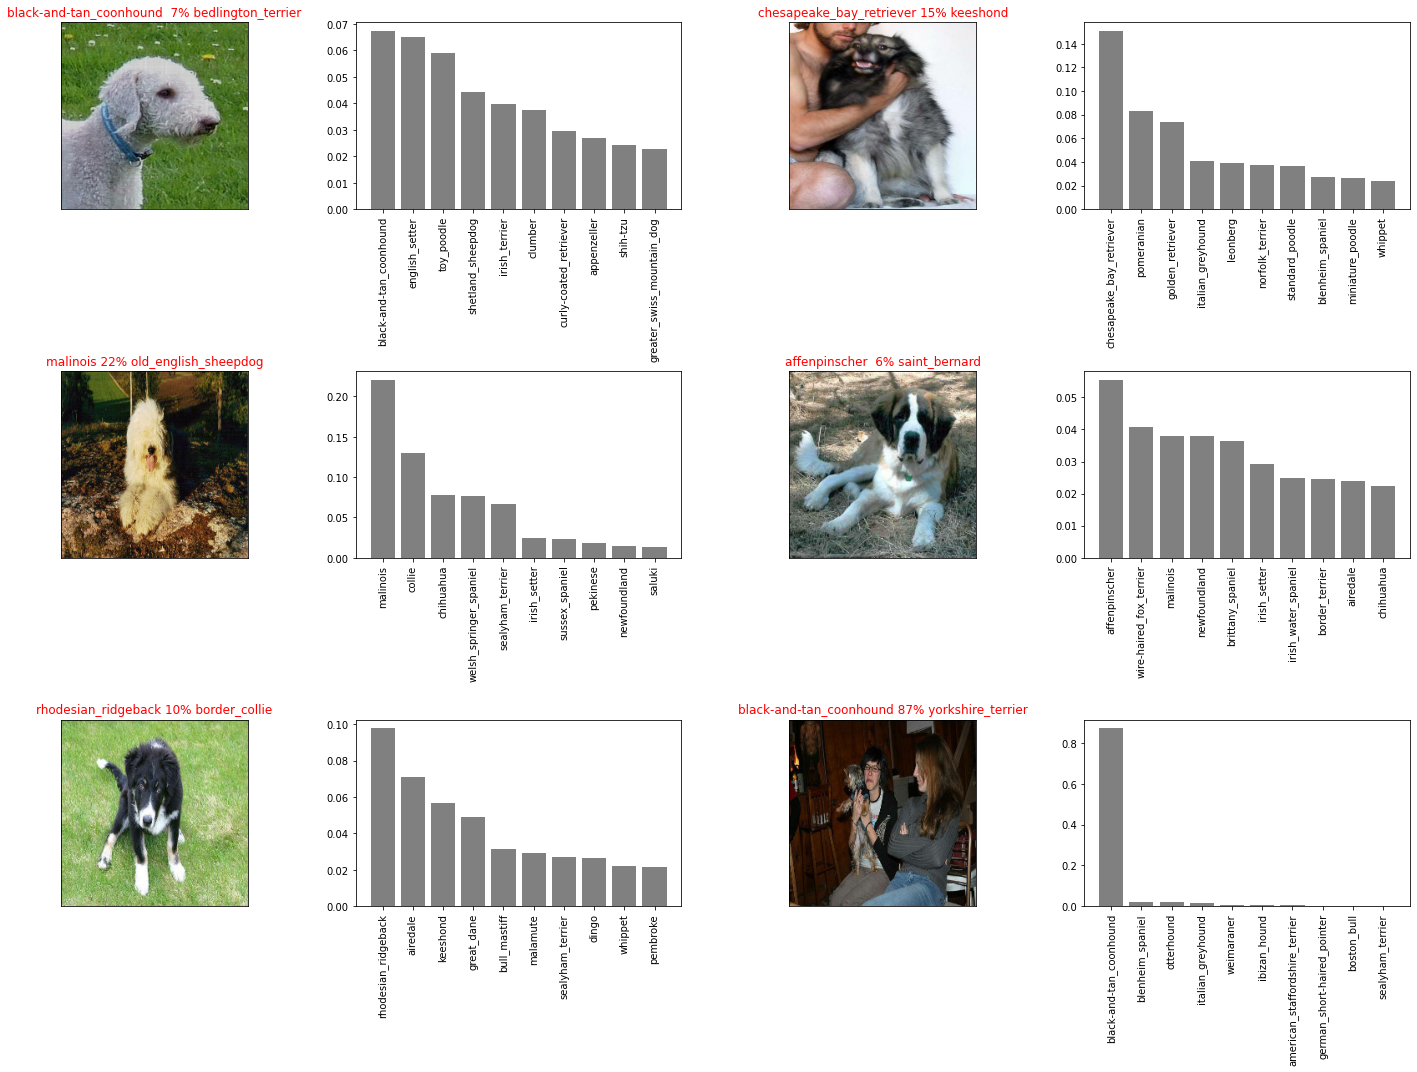

In [67]:
# Let's check out a few predictions and their different values 
i_multiplier = 5
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilites=predictions,
            labels=val_labels,
            images = val_images,
            n = i+i_multiplier)
  plt.subplot(num_rows, 2 * num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilites=predictions,
                 labels = val_labels,
                 n = i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge:** How would you create a confusion matrix with our predictions and true labels?

## Saving and reloading a traind model 

In [68]:
# Create a function to save a model 
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """

  # Create as model directory pathname with current time
  model_dir = os.path.join("drive/My Drive/Dog Vision/models",
                           datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  
  model_path = model_dir + "-" + suffix + ".h5" # Save format of model 
  print(f"Saving model to: {model_path}.....")
  model.save(model_path)
  return model_path

In [69]:
# Create a function to load a trained model 
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects ={"KerasLayer":hub.KerasLayer})
  return model 

Now we've got functions to save and load a trained model, let's make sure they work!!

In [70]:
# Save our model trained on 1000 images 
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20230322-09581679479080-1000-images-mobilenetv2-Adam.h5.....


'drive/My Drive/Dog Vision/models/20230322-09581679479080-1000-images-mobilenetv2-Adam.h5'

In [71]:
# Load a trained model 
Loaded_1000_image_model = load_model("drive/My Drive/Dog Vision/models/20230319-13021679230926-1000-images-mobilenetv2-Adam.h5")

Loading saved model from: drive/My Drive/Dog Vision/models/20230319-13021679230926-1000-images-mobilenetv2-Adam.h5


In [72]:
# Evaluate the pre-saved model 
model.evaluate(val_data)

7/7 [==============================] - 1s 88ms/step - loss: 5.8036 - Accuracy: 0.0200


[5.803554058074951, 0.019999999552965164]

In [73]:
# Evaluate the loaded model 
Loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 1s 87ms/step - loss: 1.2009 - Accuracy: 0.6700


[1.2009294033050537, 0.6700000166893005]

# Training a big dog model (on the full data)

In [74]:
len(X), len(y)

(10222, 10222)

In [75]:
# Create a data Batch with the full data set 
full_data = create_data_batches(X, y)

Creating training data batches.....


In [76]:
full_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [77]:
# Create a modle for full model 
full_model = create_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [78]:

# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# No validation dataset when we training on all the data, so we cant monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience =3 )

**Note:** Running the cell below will take a little while (maybe up to 30 mins for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [79]:
# # Fix the full model to the full data 
# full_model.fit(x=full_data,
#                epochs=NUM_EPOCHS,
#                callbacks=[full_model_tensorboard, full_model_early_stopping])

In [80]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20230322-09581679479092-full-image-set-mobilenetv2-Adam.h5.....


'drive/My Drive/Dog Vision/models/20230322-09581679479092-full-image-set-mobilenetv2-Adam.h5'

In [81]:

# Load in the full model
loaded_full_model = load_model("drive/My Drive/Dog Vision/models/20230320-14461679323591-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: drive/My Drive/Dog Vision/models/20230320-14461679323591-full-image-set-mobilenetv2-Adam.h5


In [82]:
len(X)

10222

## Making predictions on the test dataset

Since our model has beeen trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches. 

To make predictions on the test data, we'll:

* Get the test image filenames.
* Convert the filenames into the test data batches using `create_data_batches` and setting `test_data` parameter to `True` (since the test data doesn't have labels).
* Make a prediction array by passing the test batches to the `predict()` method called on our model.

In [83]:
# Load test image filenames

test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/e7be7b911a4cba9fdfa4105ec4776370.jpg',
 'drive/My Drive/Dog Vision/test/e7ce78e874945f182a4f5149aa505b09.jpg',
 'drive/My Drive/Dog Vision/test/e7dc8cc599049ea9fa2a172c88646c57.jpg',
 'drive/My Drive/Dog Vision/test/e7e9624f2a2e61ab187358f5968bfde8.jpg',
 'drive/My Drive/Dog Vision/test/e7e9dd51302fe08c1c89a550e183cf07.jpg',
 'drive/My Drive/Dog Vision/test/e7ed96b272013c6de9505a753816ce75.jpg',
 'drive/My Drive/Dog Vision/test/e7f95aabf775a636b3893ffa120adaf9.jpg',
 'drive/My Drive/Dog Vision/test/e7fcdf9671a6593b638cbee42842f981.jpg',
 'drive/My Drive/Dog Vision/test/e7feb64da6aae1ef8e62453f6660d0c5.jpg',
 'drive/My Drive/Dog Vision/test/e800b6c8d2904e205d67ada800907762.jpg']

In [84]:
len(test_filenames)

10248

In [85]:
# Create test data atch 
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches........


In [86]:
test_data

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [109]:
# Make predictions on the test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                              verbose=1)

321/321 [==============================] - 3824s 12s/step


In [111]:
# Save predictions (Numpy array) to csv file (for acess later)
np.savetxt("/content/drive/MyDrive/Dog Vision/dog-vision-prediction-probabilites-array.csv", test_predictions, delimiter=",")

In [112]:
# Load predictions (Numpy array) from csv 
test_predictions = np.loadtxt("/content/drive/MyDrive/Dog Vision/dog-vision-prediction-probabilites-array.csv", delimiter=",")

In [113]:
test_predictions[:10]

array([[1.51508580e-13, 7.65719821e-10, 6.02102829e-12, ...,
        4.24692330e-11, 7.31565077e-15, 1.76374724e-12],
       [6.88635414e-14, 5.16709743e-20, 5.18892776e-11, ...,
        5.78754286e-18, 7.63555468e-17, 4.34272355e-13],
       [4.30979523e-11, 1.03077323e-13, 8.85359359e-14, ...,
        1.80346920e-16, 2.49040732e-10, 1.51778156e-12],
       ...,
       [8.41835245e-28, 1.78917803e-23, 1.28799117e-27, ...,
        2.35441775e-21, 1.03540538e-24, 5.82052023e-32],
       [3.26291999e-14, 4.88426743e-10, 6.02798038e-16, ...,
        1.27656587e-16, 5.16146316e-13, 2.08230109e-08],
       [7.43929588e-19, 3.79677137e-24, 1.34306798e-21, ...,
        3.99943652e-08, 1.81351136e-13, 1.78438045e-21]])

In [114]:
test_predictions.shape

(10248, 120)

## Preparing the test datasets predictions for Kaggle 

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

To get data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as column for each dog breed. 
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [115]:
# Create a pandas Dataframe with empty columns 
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [116]:
# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids 

In [117]:
os.path.splitext(test_filenames[0])

('drive/My Drive/Dog Vision/test/e7be7b911a4cba9fdfa4105ec4776370', '.jpg')

In [118]:
preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7be7b911a4cba9fdfa4105ec4776370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e7ce78e874945f182a4f5149aa505b09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e7dc8cc599049ea9fa2a172c88646c57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e7e9624f2a2e61ab187358f5968bfde8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e7e9dd51302fe08c1c89a550e183cf07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10243,05b5fae69139329bef42256d8dfdedba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10244,05bb6919c2dc679ea70ffc632f68ee2b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10245,05bf0e1ba6ac406b0881ca42bd9eea97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10246,05c32f1b14ec8971333500427eccd98c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
# Add the prediction probabilities to each dog breed column 
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,e7be7b911a4cba9fdfa4105ec4776370,1.515086e-13,7.657198e-10,6.021028e-12,1.359798e-11,5.136564e-18,4.850552e-16,1.611699e-17,1.063884e-15,6.298980e-16,...,9.849467e-15,1.787379e-19,6.664514e-21,3.094276e-15,2.509970e-17,3.622371e-20,1.381904e-16,4.246923e-11,7.315651e-15,1.763747e-12
1,e7ce78e874945f182a4f5149aa505b09,6.886354e-14,5.167097e-20,5.188928e-11,7.289856e-29,1.548809e-17,3.896724e-16,7.920861e-20,5.379007e-18,5.330704e-23,...,2.644473e-15,1.002924e-17,3.704515e-18,1.270301e-21,7.090918e-16,1.585504e-21,3.286190e-18,5.787543e-18,7.635555e-17,4.342724e-13
2,e7dc8cc599049ea9fa2a172c88646c57,4.309795e-11,1.030773e-13,8.853594e-14,1.718856e-15,3.648145e-11,6.486796e-15,2.156322e-16,1.008650e-13,4.856094e-20,...,1.793576e-12,5.137821e-16,4.714446e-14,8.728338e-15,1.563772e-13,1.154831e-15,4.551392e-11,1.803469e-16,2.490407e-10,1.517782e-12
3,e7e9624f2a2e61ab187358f5968bfde8,8.890923e-17,3.792339e-19,4.751945e-18,5.600821e-20,1.686442e-15,2.806559e-16,1.159000e-20,7.114530e-15,1.495496e-16,...,1.507111e-15,1.682149e-16,6.755191e-14,1.020384e-16,3.645848e-18,1.442386e-15,6.138455e-19,7.745750e-18,1.469219e-16,2.617164e-19
4,e7e9dd51302fe08c1c89a550e183cf07,5.475255e-07,1.097514e-15,4.104629e-17,1.153567e-13,3.551475e-13,3.474065e-17,6.585560e-04,1.604586e-15,8.403566e-18,...,8.940349e-14,1.330637e-07,3.512043e-16,1.957087e-18,2.121961e-17,7.529464e-17,1.660999e-11,1.141897e-13,3.914408e-10,9.993396e-01


In [122]:
# Add the prediction probabilities to each dog bree column 
preds_df[list(unique_breeds)]

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,1.515086e-13,7.657198e-10,6.021028e-12,1.359798e-11,5.136564e-18,4.850552e-16,1.611699e-17,1.063884e-15,6.298980e-16,1.138681e-22,...,9.849467e-15,1.787379e-19,6.664514e-21,3.094276e-15,2.509970e-17,3.622371e-20,1.381904e-16,4.246923e-11,7.315651e-15,1.763747e-12
1,6.886354e-14,5.167097e-20,5.188928e-11,7.289856e-29,1.548809e-17,3.896724e-16,7.920861e-20,5.379007e-18,5.330704e-23,4.418189e-26,...,2.644473e-15,1.002924e-17,3.704515e-18,1.270301e-21,7.090918e-16,1.585504e-21,3.286190e-18,5.787543e-18,7.635555e-17,4.342724e-13
2,4.309795e-11,1.030773e-13,8.853594e-14,1.718856e-15,3.648145e-11,6.486796e-15,2.156322e-16,1.008650e-13,4.856094e-20,2.456619e-17,...,1.793576e-12,5.137821e-16,4.714446e-14,8.728338e-15,1.563772e-13,1.154831e-15,4.551392e-11,1.803469e-16,2.490407e-10,1.517782e-12
3,8.890923e-17,3.792339e-19,4.751945e-18,5.600821e-20,1.686442e-15,2.806559e-16,1.159000e-20,7.114530e-15,1.495496e-16,1.243598e-18,...,1.507111e-15,1.682149e-16,6.755191e-14,1.020384e-16,3.645848e-18,1.442386e-15,6.138455e-19,7.745750e-18,1.469219e-16,2.617164e-19
4,5.475255e-07,1.097514e-15,4.104629e-17,1.153567e-13,3.551475e-13,3.474065e-17,6.585560e-04,1.604586e-15,8.403566e-18,2.445056e-17,...,8.940349e-14,1.330637e-07,3.512043e-16,1.957087e-18,2.121961e-17,7.529464e-17,1.660999e-11,1.141897e-13,3.914408e-10,9.993396e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10243,1.926875e-16,1.888021e-12,3.338737e-14,4.317861e-11,2.813484e-17,4.850186e-18,9.489511e-24,8.882874e-22,1.629233e-17,2.053618e-19,...,8.529061e-15,2.087646e-19,4.026493e-07,1.687792e-11,4.200728e-11,7.089856e-22,4.425280e-20,3.777772e-08,3.527768e-18,2.288036e-17
10244,7.509849e-13,5.001760e-17,2.300639e-15,1.068567e-15,5.108945e-15,1.122678e-11,1.355741e-15,4.334965e-14,9.379727e-18,3.991529e-15,...,1.941345e-12,3.721911e-12,3.860997e-15,1.162105e-17,7.137547e-17,4.640665e-17,1.926587e-12,1.705026e-16,1.889497e-11,9.634863e-12
10245,1.270632e-17,3.531522e-22,3.062096e-25,1.072463e-20,1.189252e-20,1.807845e-21,2.162324e-18,8.399467e-23,9.439406e-25,7.728559e-26,...,1.143928e-19,4.684862e-23,2.544230e-24,1.196222e-20,1.743808e-22,9.316187e-21,1.211878e-31,1.604586e-27,1.712391e-21,6.469025e-23
10246,7.838786e-14,1.645998e-09,4.530353e-17,3.184096e-19,1.796286e-16,8.481655e-17,1.148399e-14,6.504361e-14,1.257642e-11,8.405115e-20,...,1.574189e-08,4.287967e-21,6.566131e-16,1.660726e-19,3.909476e-18,2.888647e-16,1.164217e-20,2.231345e-18,5.880618e-14,1.443680e-10


In [123]:
# Save our predictions dataframe to CSV for submission to Kaggle 
preds_df.to_csv("drive/My Drive/Dog Vision/full-model-prediction-submission_1_mobilnetV2.csv",
                index=False)

## Making predictions on custom images 

To make predictions on custom images, we'll :
  * Get the filepaths of our own images.
  * Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data()` parameter to `True`.
  * Pass the custom image data batch to our model's `predict()` method.
  * Convert the prediction output probabilities to predictions labels.
  * Compare the predicted lables to the custom images. 
